In [ ]:
!pip3 install kaggle
!pip3 install keras-Preprocessing

Flickr 8k dataset that contains 8K images and its correspondant caption. This dataset is designed for training and testing models used for captioning or image description tasks. The goal is to generate the appropriate captioning for the image at hand.

In [2]:
!kaggle datasets download sakshighadigaonkar/flickr-8k

Dataset URL: https://www.kaggle.com/datasets/sakshighadigaonkar/flickr-8k
License(s): unknown
100%|██████████████████████████████████████| 1.04G/1.04G [00:53<00:00, 19.2MB/s]
100%|██████████████████████████████████████| 1.04G/1.04G [00:53<00:00, 20.8MB/s]


In [87]:
!kaggle datasets download yesornope/glove6b

Dataset URL: https://www.kaggle.com/datasets/yesornope/glove6b
License(s): unknown
100%|███████████████████████████████████████▉| 844M/844M [04:21<00:00, 23.3MB/s]
100%|████████████████████████████████████████| 844M/844M [04:21<00:00, 3.39MB/s]


In [88]:
!unzip glove6b.zip

Archive:  glove6b.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
from keras import Input, layers, optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence, image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.utils import to_categorical

# EDA of flickr-8k dataset

- analysis
- prepare dataset

In [27]:
# EDA of flickr-8k dataset

from collections import defaultdict

img2desc = "./data/flickr-8k/Flickr8k_text/Flickr8k.token.txt"
train_img_paths = './data/flickr-8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_img_paths = './data/flickr-8k/Flickr8k_text/Flickr_8k.testImages.txt'
img_dir_path = './data/flickr-8k/Flickr8k_Dataset/Flicker8k_Dataset'

with open(img2desc, "r") as f:
    doc = f.read()
    
description_dict = defaultdict(list)
for line in doc.split('\n'):
    tokens = line.split()
    if len(line) > 2:
        img_id = tokens[0].split('.')[0]
        img_desc = ' '.join(tokens[1:])
        if img_id not in descs:
            descriptions = description_dict[img_id]
            descriptions += [img_desc]

print(f"Number of img_id: {len(description_dict)}")

Number of img_id: 8092


<class 'numpy.ndarray'>
(500, 375, 3)


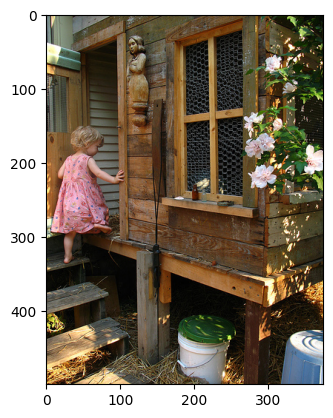

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [23]:
img_array = plt.imread(os.path.join(img_dir_path, "1000268201_693b08cb0e.jpg"))
print(type(img_array))
print(img_array.shape)

plt.imshow(img_array)
plt.show()

for desc in description_dict["1000268201_693b08cb0e"]:
    print(desc)

In [26]:
# get vocabulary set

vocab = set()
for img_id, descs in description_dict.items():
    for desc in descs:
        words = desc.split()
        vocab.update(words)
print(f"Original vocabulary size: {len(vocab)} words")

Original vocabulary size: 9630 words


In [28]:
# prepare dataset: "{img_id} {description}"

lines = list()
for img_id, descs in description_dict.items():
    for desc in descs:
        lines.append(f"{img_id} {desc}")
        
descriptions = '\n'.join(lines)

In [33]:
dataset = list()

with open(train_img_paths, "r") as f:
    doc = f.read()
    for line in doc.split("\n"):
        if len(line) > 1:
            img_id = line.split('.')[0]
            dataset.append(img_id)

In [62]:
img_paths = glob.glob(img_dir_path + "/*.jpg")
with open(train_img_paths, 'r') as f:
    _train_img_paths = f.read()
    _train_img_paths = _train_img_paths.strip().split('\n')
    
with open(test_img_paths, 'r') as f:
    _test_img_paths = f.read()
    _test_img_paths = _test_img_paths.strip().split('\n')

train_img_full_paths, test_img_full_paths = [], []
for img_path in img_paths:
    _img_path = img_path.split('/')[-1]
    if _img_path in _train_img_paths:
        train_img_full_paths += [img_path]

    if _img_path in _test_img_paths:
        test_img_full_paths += [img_path]

In [63]:
len(train_img_full_paths), len(test_img_full_paths)

(6000, 1000)

In [67]:
for img_id, descs in description_dict.items():
    new_descs = []
    for desc in descs:
        new_descs += [f"startseq {desc} endseq"]
    description_dict[img_id] = new_descs

In [82]:
train_descriptions = dict()
for line in descriptions.split('\n'):
    tokens = line.split()
    img_id, img_desc = tokens[0], tokens[1:]
    if img_id in dataset:
        if img_id not in train_descriptions:
            train_descriptions[img_id] = list()
        desc = 'startseq ' + ' '.join(img_desc) + ' endseq' # adding the start and end sequence tokens for latter transformation
        train_descriptions[img_id].append(desc)

In [97]:
# Filtering out less relevant words from our description vocabulary. 
captions = [desc for _, descs in train_descriptions.items() for desc in descs]

word_count_threshold = 10
word_counts = {}
n_sents = 0
for sent in captions:
    n_sents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
        
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary size for words that have 10 or more occurrences= %d' % (len(vocab)))

Vocabulary size for words that have 10 or more occurrences= 1698


In [84]:
# build up our mapping to map each word to an index.

idx2word = {}
word2idx = {}
idx = 1
for w in vocab:
    word2idx[w] = idx
    idx2word[idx] = w
    idx += 1

vocab_size = len(idx2word) + 1

In [86]:
# capture the longest description in our description data set.
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 40


## Embedding process

In [89]:
glove_path = './data/glove6b/'

embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [91]:
print('the', embeddings_index['the'].shape)
print('child', embeddings_index['child'].shape)

the (200,)
child (200,)


In [92]:
# Now for every single words stored in our mapping word to index (wordtoix), we obtain its embedding representation from Glove pretrain vectors
# and we create our embedding matrix where index i contains the embedding vector of word with index i. Our matrix dimension will be defined as 
# vocab_size (1699) and 200 embeedings based on the specific pretrained vector data set we are using. 
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [101]:
print(embedding_matrix.shape)

(1699, 200)


In [ ]:
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

In [109]:
from tensorflow.keras.utils import load_img, img_to_array

def preprocess(img_path):
    img = load_img(img_path, target_size=(299, 299)) # img_height, img_width
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) # inception
    return x

print(len(train_img_full_paths))

6000


In [125]:
x = preprocess(train_img_full_paths[0])
model_new.predict(x).shape

1/1 [==============================] - 0s 91ms/step


(1, 2048)

In [ ]:
def embed(img_path, model):
    img = preprocess(img_path) 
    fea_vec = model.predict(img) # (1, 2048)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

train_features = {}
for img in train_img_full_paths:
    train_features[img] = embed(img, model_new)

test_features = {}
for img in test_img_full_paths:
    test_features[img] = embed(img, model_new)

In [201]:
import pickle

with open("./data/img_caption.train_features.pickle", "wb") as fw:
    pickle.dump(train_features, fw)

with open("./data/img_caption.test_features.pickle", "wb") as fw:
    pickle.dump(test_features, fw)

## Simple Modeling (Bimodel)

In [142]:
from keras.layers import Embedding, Dropout, Dense, add, LSTM

inputs1 = Input(shape=(2048,)) # Image input
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,)) # text input
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3]) # join modality --> Additive fusion
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 40, 200)      339800      ['input_10[0][0]']               
                                                                                                  
 dropout_5 (Dropout)            (None, 2048)         0           ['input_9[0][0]']                
                                                                                            

In [147]:
model.layers[2].set_weights([embedding_matrix]) # Setting up the weigths of embedding layer as the weights obtained after appliying Glove pretained vectors
model.layers[2].trainable = False # we make the layer not trainable as we do not want that the model updates/learns anything from the inference generated.

In [148]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [187]:
# generates the actual input pair and output by combining each photo with each of its captions and use another caption as output. 

def data_generator(
    descriptions:dict,
    img_dir_path: str,
    features: dict,
    word2idx: dict,
    max_length: int,
    num_photos_per_batch: int
):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for img_id, descs in descriptions.items():
            n+=1
            # retrieve the photo feature
            ndarray = features[img_dir_path + "/" + img_id + '.jpg']
            for desc in descs:
                # encode the sequence
                seq = [word2idx[word] for word in desc.split(' ') if word in word2idx]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(ndarray)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

epochs = 15
batch_size = 8

steps, remainder = divmod(len(train_descriptions), batch_size) 
if remainder != 0:
    steps += 1
    
steps = len(train_descriptions) // batch_size
generator = data_generator(train_descriptions, img_dir_path, train_features, word2idx, max_length, batch_size)

In [192]:
_input, _output = next(generator)
print(_input[0].shape, _input[1].shape, _output.shape)

(489, 2048) (489, 40) (489, 1699)


In [194]:
generator = data_generator(train_descriptions, img_dir_path, train_features, word2idx, max_length, batch_size)

In [202]:
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/15
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f868c1198b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f868c1198b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original 

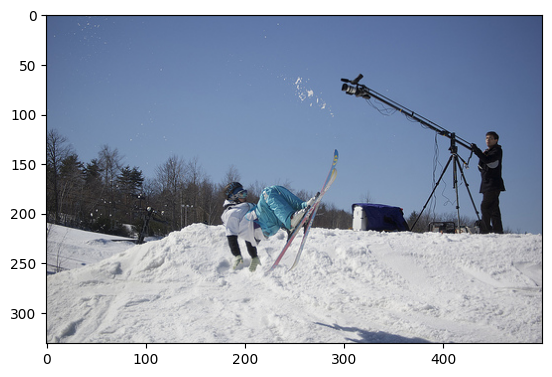

A man is walking through the snow . 
startseq A man is walking through the snow . endseq
A people are standing on top of a snow covered mountain .


In [228]:
import random
from keras_preprocessing.sequence import pad_sequences

def greedy_search(model, feature: np.ndarray, max_length: int, word2idx: dict, idx2word) -> str:
    in_text = "startseq"
    for i in range(max_length):
        seq = [word2idx[word] for word in in_text.split() if word in word2idx]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([feature, seq], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += f" {word}"
        if word == "endseq":
            print("", end="\n")
            break
        else:
            print(word, end=" ", flush=True)
    return in_text


def beam_search(model, feature, max_length, word2idx, idx2word, beam_size=3):
    start = [word2idx["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([feature, par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_size:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_size:]
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

# select test image and draw
img_path = random.sample(list(test_features.keys()), 1)[0]
img_feature = test_features[img_path].reshape((1, 2048))
x = plt.imread(img_path)
plt.imshow(x)
plt.show()

# predict with model
caption = greedy_search(model, img_feature, max_length, word2idx, idx2word)
print(caption)

caption = beam_search(model, img_feature, max_length, word2idx, idx2word, 3)
print(caption)